In [72]:
from __future__ import print_function

from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [78]:
nteams = 20
nmatches = (nteams-1)*2

In [79]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'

Data Pre-processing

In [80]:
def season_team_map(season_dir):
    readme = season_dir + '/README.md'
    f = open(readme, 'r')
    
    s = "  "
    
    # skip to teams
    while(s[1] != '1'):
        s = f.readline()
        if(len(s)<=1):
            s = "  "

    team_map = {}

    for i in range(20):
        team_map[s[4:].split('  ')[0]] = i
        s = f.readline()

    f.close()
    
    return team_map

In [81]:
def season_game_mat(season_dir, team_map):
    game_mat = np.zeros((nteams, nmatches), dtype=int)
    team_index = np.zeros(nteams, dtype=int)

    csvfile = ''
    
    for entry in os.scandir(season_dir):
        if '/1-' in entry.path:
            csvfile = entry.path
            
    with open(csvfile) as gf:
        reader = csv.reader(gf)
        next(reader)
        for row in reader:
            team1 = team_map[row[1]]
            team2 = team_map[row[2]]

            score = row[3].split('-')

            # 1 for win, 0 for draw, -1 for loss

            if(int(score[0]) > int(score[1])):
                game_mat[team1, team_index[team1]] = 1
                game_mat[team2, team_index[team2]] = -1
            elif(int(score[0]) < int(score[1])):
                game_mat[team1, team_index[team1]] = -1
                game_mat[team2, team_index[team2]] = 1

            team_index[team1] += 1
            team_index[team2] += 1
    
    return np.transpose(game_mat)

In [82]:
country_dirs = []
season_dirs = []

nseasons = 0
team_maps = []
game_mats = []

for entry in os.scandir('./data'):
    if entry.is_dir():
        country_dirs.append(entry.path)

for cdir in country_dirs:
    for entry in os.scandir(cdir):
        if entry.is_dir():
            season_dir = entry.path
            team_maps.append(season_team_map(season_dir))
            game_mats.append(season_game_mat(season_dir, team_maps[nseasons]))
            nseasons += 1

In [14]:
def eucl_error(outputs, targets):
    return np.mean(np.abs(targets - outputs))

In [15]:
def disc_error(outputs, targets):
    rounded_outputs = np.round(outputs)
    err = 0
    n = 0
    for i in range(len(outputs)):
        for j in range(len(outputs[i])):
            if(int(rounded_outputs[i][j]) != int(targets[i][j])):
                err += 1
            n += 1
    return float(err)/n

In [16]:
ntraining = 45
ntesting = nseasons - ntraining

training_game_mats = game_mats[:ntraining]
testing_game_mats = game_mats[ntesting:]

X_training = np.reshape(np.array(training_game_mats), (ntraining*nmatches, nteams))
lengths = np.full(ntraining, nmatches)

In [33]:
X_trainings = []
Y_trainings = []
for i in range(1, nmatches):
    X_training = []
    Y_training = []
    for game_mat in training_game_mats:
        for j in range(nmatches-i):
            X_training.append(np.ndarray.flatten(game_mat[j:j+i]))
            Y_training.append(game_mat[j+i])
    
    X_training = np.array(X_training).reshape(-1,i,nteams)
    Y_training = np.array(Y_training).reshape(-1,nteams)
    X_trainings.append(X_training)
    Y_trainings.append(Y_training)

In [34]:
X_testings = []
Y_testings = []
for i in range(1, nmatches):
    X_testing = []
    Y_testing = []
    for game_mat in testing_game_mats:
        for j in range(nmatches-i):
            X_testing.append(np.ndarray.flatten(game_mat[j:j+i]))
            Y_testing.append(game_mat[j+i])
            
    X_testing = np.array(X_testing).reshape(-1,i,nteams)
    Y_testing = np.array(Y_testing).reshape(-1,nteams)
    X_testings.append(X_testing)
    Y_testings.append(Y_testing)

In [44]:
layer_sizes = [30, 50, 100, 200]

In [47]:
rnns = {}
for size in layer_sizes:
    key = str(size)+'_neuron_layers'
    rnns[key] = []

In [48]:
for i in range(nmatches-1):
    for size in layer_sizes:
        key = str(size)+'_neuron_layers'       
        # define the LSTM model
        model = Sequential()
        model.add(LSTM(size, input_shape=(i+1, nteams)))
        model.add(Dropout(0.2))
        #model.add(Dense(nteams, activation='softmax'))
        model.add(Dense(nteams, activation='tanh'))
        #model.compile(loss='categorical_crossentropy', optimizer='adam')
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(X_trainings[i], np.array(Y_trainings[i]), epochs=20)
        rnns[key].append(model)

Epoch 1/20
1665/1665 [==============================] - 2s 911us/step - loss: 0.7337
Epoch 2/20
1665/1665 [==============================] - 0s 114us/step - loss: 0.7056
Epoch 3/20
1665/1665 [==============================] - 0s 116us/step - loss: 0.6917
Epoch 4/20
1665/1665 [==============================] - 0s 118us/step - loss: 0.6847
Epoch 5/20
1665/1665 [==============================] - 0s 132us/step - loss: 0.6793
Epoch 6/20
1665/1665 [==============================] - 0s 122us/step - loss: 0.6776
Epoch 7/20
1665/1665 [==============================] - 0s 118us/step - loss: 0.6763
Epoch 8/20
1665/1665 [==============================] - ETA: 0s - loss: 0.673 - 0s 118us/step - loss: 0.6735
Epoch 9/20
1665/1665 [==============================] - 0s 122us/step - loss: 0.6725 0s - loss: 0.67
Epoch 10/20
1665/1665 [==============================] - 0s 113us/step - loss: 0.6713
Epoch 11/20
1665/1665 [==============================] - 0s 105us/step - loss: 0.6709
Epoch 12/20
1665/1665 [

Epoch 16/20
1620/1620 [==============================] - 0s 125us/step - loss: 0.6644
Epoch 17/20
1620/1620 [==============================] - 0s 115us/step - loss: 0.6656
Epoch 18/20
1620/1620 [==============================] - 0s 148us/step - loss: 0.6629
Epoch 19/20
1620/1620 [==============================] - 0s 133us/step - loss: 0.6624
Epoch 20/20
1620/1620 [==============================] - 0s 113us/step - loss: 0.6604
Epoch 1/20
1620/1620 [==============================] - 2s 942us/step - loss: 0.7248
Epoch 2/20
1620/1620 [==============================] - 0s 110us/step - loss: 0.6926
Epoch 3/20
1620/1620 [==============================] - 0s 111us/step - loss: 0.6809
Epoch 4/20
1620/1620 [==============================] - 0s 116us/step - loss: 0.6789
Epoch 5/20
1620/1620 [==============================] - 0s 127us/step - loss: 0.6749
Epoch 6/20
1620/1620 [==============================] - 0s 116us/step - loss: 0.6733
Epoch 7/20
1620/1620 [==============================] - 0s 1

1575/1575 [==============================] - 0s 169us/step - loss: 0.6632
Epoch 12/20
1575/1575 [==============================] - 0s 162us/step - loss: 0.6612
Epoch 13/20
1575/1575 [==============================] - 0s 142us/step - loss: 0.6598
Epoch 14/20
1575/1575 [==============================] - 0s 148us/step - loss: 0.6584
Epoch 15/20
1575/1575 [==============================] - 0s 146us/step - loss: 0.6569
Epoch 16/20
1575/1575 [==============================] - 0s 140us/step - loss: 0.6555
Epoch 17/20
1575/1575 [==============================] - 0s 153us/step - loss: 0.6543
Epoch 18/20
1575/1575 [==============================] - 0s 184us/step - loss: 0.6513
Epoch 19/20
1575/1575 [==============================] - 0s 161us/step - loss: 0.6497
Epoch 20/20
1575/1575 [==============================] - 0s 153us/step - loss: 0.6490
Epoch 1/20
1575/1575 [==============================] - 2s 1ms/step - loss: 0.7074
Epoch 2/20
1575/1575 [==============================] - 0s 185us/step

1530/1530 [==============================] - 0s 231us/step - loss: 0.6647
Epoch 7/20
1530/1530 [==============================] - 0s 217us/step - loss: 0.6629
Epoch 8/20
1530/1530 [==============================] - 0s 206us/step - loss: 0.6600
Epoch 9/20
1530/1530 [==============================] - 0s 208us/step - loss: 0.6585
Epoch 10/20
1530/1530 [==============================] - 0s 213us/step - loss: 0.6554
Epoch 11/20
1530/1530 [==============================] - 0s 239us/step - loss: 0.6519
Epoch 12/20
1530/1530 [==============================] - 0s 186us/step - loss: 0.6497
Epoch 13/20
1530/1530 [==============================] - 0s 231us/step - loss: 0.6468
Epoch 14/20
1530/1530 [==============================] - 0s 197us/step - loss: 0.6457
Epoch 15/20
1530/1530 [==============================] - 0s 201us/step - loss: 0.6404
Epoch 16/20
1530/1530 [==============================] - 0s 224us/step - loss: 0.6348
Epoch 17/20
1530/1530 [==============================] - 0s 273us/ste

1485/1485 [==============================] - 3s 2ms/step - loss: 0.6937
Epoch 2/20
1485/1485 [==============================] - 1s 403us/step - loss: 0.6753
Epoch 3/20
1485/1485 [==============================] - 1s 358us/step - loss: 0.6694
Epoch 4/20
1485/1485 [==============================] - 1s 354us/step - loss: 0.6653
Epoch 5/20
1485/1485 [==============================] - 1s 348us/step - loss: 0.6614
Epoch 6/20
1485/1485 [==============================] - 1s 426us/step - loss: 0.6573
Epoch 7/20
1485/1485 [==============================] - 1s 367us/step - loss: 0.6550
Epoch 8/20
1485/1485 [==============================] - 1s 352us/step - loss: 0.6522
Epoch 9/20
1485/1485 [==============================] - 1s 505us/step - loss: 0.6474
Epoch 10/20
1485/1485 [==============================] - 1s 429us/step - loss: 0.6429
Epoch 11/20
1485/1485 [==============================] - 1s 443us/step - loss: 0.6376
Epoch 12/20
1485/1485 [==============================] - 1s 533us/step - los

1440/1440 [==============================] - 1s 432us/step - loss: 0.5824
Epoch 17/20
1440/1440 [==============================] - 1s 365us/step - loss: 0.5634
Epoch 18/20
1440/1440 [==============================] - 1s 412us/step - loss: 0.5430
Epoch 19/20
1440/1440 [==============================] - 1s 393us/step - loss: 0.5187
Epoch 20/20
1440/1440 [==============================] - 1s 397us/step - loss: 0.5008
Epoch 1/20
1395/1395 [==============================] - 4s 3ms/step - loss: 0.7335
Epoch 2/20
1395/1395 [==============================] - 0s 231us/step - loss: 0.6993
Epoch 3/20
1395/1395 [==============================] - 0s 229us/step - loss: 0.6901
Epoch 4/20
1395/1395 [==============================] - 0s 235us/step - loss: 0.6869
Epoch 5/20
1395/1395 [==============================] - 0s 235us/step - loss: 0.6820
Epoch 6/20
1395/1395 [==============================] - 0s 236us/step - loss: 0.6796
Epoch 7/20
1395/1395 [==============================] - 0s 239us/step - lo

1350/1350 [==============================] - 0s 269us/step - loss: 0.6694
Epoch 13/20
1350/1350 [==============================] - 0s 272us/step - loss: 0.6675 0s - loss: 
Epoch 14/20
1350/1350 [==============================] - 0s 280us/step - loss: 0.6662
Epoch 15/20
1350/1350 [==============================] - 0s 309us/step - loss: 0.6652
Epoch 16/20
1350/1350 [==============================] - 0s 337us/step - loss: 0.6645
Epoch 17/20
1350/1350 [==============================] - 0s 307us/step - loss: 0.6614
Epoch 18/20
1350/1350 [==============================] - 0s 303us/step - loss: 0.6613
Epoch 19/20
1350/1350 [==============================] - 0s 277us/step - loss: 0.6606
Epoch 20/20
1350/1350 [==============================] - 0s 272us/step - loss: 0.6571
Epoch 1/20
1350/1350 [==============================] - 4s 3ms/step - loss: 0.7118
Epoch 2/20
1350/1350 [==============================] - 0s 265us/step - loss: 0.6870
Epoch 3/20
1350/1350 [==============================] - 0s

1305/1305 [==============================] - 0s 329us/step - loss: 0.6690
Epoch 8/20
1305/1305 [==============================] - 0s 300us/step - loss: 0.6657
Epoch 9/20
1305/1305 [==============================] - 0s 290us/step - loss: 0.6639
Epoch 10/20
1305/1305 [==============================] - 0s 291us/step - loss: 0.6620
Epoch 11/20
1305/1305 [==============================] - 0s 292us/step - loss: 0.6581
Epoch 12/20
1305/1305 [==============================] - 0s 290us/step - loss: 0.6571
Epoch 13/20
1305/1305 [==============================] - 0s 306us/step - loss: 0.6532
Epoch 14/20
1305/1305 [==============================] - 1s 397us/step - loss: 0.6514
Epoch 15/20
1305/1305 [==============================] - 0s 376us/step - loss: 0.6489 0s - loss
Epoch 16/20
1305/1305 [==============================] - 0s 312us/step - loss: 0.6477
Epoch 17/20
1305/1305 [==============================] - 0s 310us/step - loss: 0.6434
Epoch 18/20
1305/1305 [==============================] - 0

1260/1260 [==============================] - 0s 376us/step - loss: 0.6836
Epoch 3/20
1260/1260 [==============================] - 0s 388us/step - loss: 0.6759
Epoch 4/20
1260/1260 [==============================] - 1s 421us/step - loss: 0.6709
Epoch 5/20
1260/1260 [==============================] - 0s 368us/step - loss: 0.6664
Epoch 6/20
1260/1260 [==============================] - 0s 366us/step - loss: 0.6622
Epoch 7/20
1260/1260 [==============================] - 0s 371us/step - loss: 0.6578
Epoch 8/20
1260/1260 [==============================] - 0s 363us/step - loss: 0.6551
Epoch 9/20
1260/1260 [==============================] - 0s 367us/step - loss: 0.6511
Epoch 10/20
1260/1260 [==============================] - 0s 370us/step - loss: 0.6482
Epoch 11/20
1260/1260 [==============================] - 1s 431us/step - loss: 0.6432
Epoch 12/20
1260/1260 [==============================] - 1s 414us/step - loss: 0.6411
Epoch 13/20
1260/1260 [==============================] - 1s 500us/step - 

1215/1215 [==============================] - 1s 547us/step - loss: 0.6069 0s - loss
Epoch 18/20
1215/1215 [==============================] - 1s 460us/step - loss: 0.6015
Epoch 19/20
1215/1215 [==============================] - 1s 494us/step - loss: 0.5925
Epoch 20/20
1215/1215 [==============================] - 1s 503us/step - loss: 0.5813
Epoch 1/20
1215/1215 [==============================] - 7s 5ms/step - loss: 0.6991
Epoch 2/20
1215/1215 [==============================] - 1s 1ms/step - loss: 0.6752
Epoch 3/20
1215/1215 [==============================] - 1s 707us/step - loss: 0.6688
Epoch 4/20
1215/1215 [==============================] - 1s 907us/step - loss: 0.6592
Epoch 5/20
1215/1215 [==============================] - 1s 807us/step - loss: 0.6550
Epoch 6/20
1215/1215 [==============================] - 1s 650us/step - loss: 0.6511
Epoch 7/20
1215/1215 [==============================] - 1s 1ms/step - loss: 0.6456
Epoch 8/20
1215/1215 [==============================] - 1s 723us/step

1170/1170 [==============================] - 1s 682us/step - loss: 0.6104
Epoch 13/20
1170/1170 [==============================] - 1s 670us/step - loss: 0.5986
Epoch 14/20
1170/1170 [==============================] - 1s 596us/step - loss: 0.5877
Epoch 15/20
1170/1170 [==============================] - 1s 589us/step - loss: 0.5709
Epoch 16/20
1170/1170 [==============================] - 1s 574us/step - loss: 0.5541
Epoch 17/20
1170/1170 [==============================] - 1s 589us/step - loss: 0.5370
Epoch 18/20
1170/1170 [==============================] - 1s 578us/step - loss: 0.5216
Epoch 19/20
1170/1170 [==============================] - 1s 583us/step - loss: 0.4985
Epoch 20/20
1170/1170 [==============================] - 1s 573us/step - loss: 0.4808
Epoch 1/20
1125/1125 [==============================] - 5s 5ms/step - loss: 0.7387
Epoch 2/20
1125/1125 [==============================] - 0s 379us/step - loss: 0.7060
Epoch 3/20
1125/1125 [==============================] - 0s 379us/step 

1080/1080 [==============================] - 0s 414us/step - loss: 0.6784
Epoch 8/20
1080/1080 [==============================] - 0s 411us/step - loss: 0.6750
Epoch 9/20
1080/1080 [==============================] - 0s 416us/step - loss: 0.6731
Epoch 10/20
1080/1080 [==============================] - 0s 410us/step - loss: 0.6717
Epoch 11/20
1080/1080 [==============================] - 0s 419us/step - loss: 0.6692
Epoch 12/20
1080/1080 [==============================] - 0s 449us/step - loss: 0.6683
Epoch 13/20
1080/1080 [==============================] - 0s 432us/step - loss: 0.6669
Epoch 14/20
1080/1080 [==============================] - 0s 415us/step - loss: 0.6664
Epoch 15/20
1080/1080 [==============================] - 0s 416us/step - loss: 0.6637
Epoch 16/20
1080/1080 [==============================] - 0s 420us/step - loss: 0.6632
Epoch 17/20
1080/1080 [==============================] - 0s 416us/step - loss: 0.6606
Epoch 18/20
1080/1080 [==============================] - 0s 411us/st

1035/1035 [==============================] - 0s 441us/step - loss: 0.6874
Epoch 3/20
1035/1035 [==============================] - 0s 435us/step - loss: 0.6829
Epoch 4/20
1035/1035 [==============================] - 0s 435us/step - loss: 0.6782
Epoch 5/20
1035/1035 [==============================] - 0s 441us/step - loss: 0.6738
Epoch 6/20
1035/1035 [==============================] - 0s 439us/step - loss: 0.6697
Epoch 7/20
1035/1035 [==============================] - 0s 440us/step - loss: 0.6679
Epoch 8/20
1035/1035 [==============================] - 0s 444us/step - loss: 0.6642
Epoch 9/20
1035/1035 [==============================] - 0s 466us/step - loss: 0.6633
Epoch 10/20
1035/1035 [==============================] - 0s 425us/step - loss: 0.6596
Epoch 11/20
1035/1035 [==============================] - 0s 427us/step - loss: 0.6570
Epoch 12/20
1035/1035 [==============================] - 0s 435us/step - loss: 0.6523
Epoch 13/20
1035/1035 [==============================] - 0s 427us/step - 

Epoch 18/20
990/990 [==============================] - 0s 464us/step - loss: 0.6407
Epoch 19/20
990/990 [==============================] - 0s 461us/step - loss: 0.6361
Epoch 20/20
990/990 [==============================] - 0s 457us/step - loss: 0.6351
Epoch 1/20
990/990 [==============================] - 7s 7ms/step - loss: 0.7143
Epoch 2/20
990/990 [==============================] - 0s 502us/step - loss: 0.6835
Epoch 3/20
990/990 [==============================] - 1s 509us/step - loss: 0.6760
Epoch 4/20
990/990 [==============================] - 0s 499us/step - loss: 0.6698
Epoch 5/20
990/990 [==============================] - 1s 509us/step - loss: 0.6668
Epoch 6/20
990/990 [==============================] - 1s 637us/step - loss: 0.6602
Epoch 7/20
990/990 [==============================] - 1s 510us/step - loss: 0.6555
Epoch 8/20
990/990 [==============================] - 0s 486us/step - loss: 0.6526
Epoch 9/20
990/990 [==============================] - 1s 505us/step - loss: 0.6484
Epo

945/945 [==============================] - 1s 770us/step - loss: 0.6155 0s - loss: 0
Epoch 16/20
945/945 [==============================] - 1s 703us/step - loss: 0.6091
Epoch 17/20
945/945 [==============================] - 1s 597us/step - loss: 0.6014
Epoch 18/20
945/945 [==============================] - 1s 902us/step - loss: 0.5959
Epoch 19/20
945/945 [==============================] - 1s 710us/step - loss: 0.5894
Epoch 20/20
945/945 [==============================] - 1s 636us/step - loss: 0.5838
Epoch 1/20
945/945 [==============================] - 8s 8ms/step - loss: 0.6954
Epoch 2/20
945/945 [==============================] - 1s 863us/step - loss: 0.6764
Epoch 3/20
945/945 [==============================] - 1s 869us/step - loss: 0.6680
Epoch 4/20
945/945 [==============================] - 1s 859us/step - loss: 0.6600
Epoch 5/20
945/945 [==============================] - 1s 962us/step - loss: 0.6543 0s -
Epoch 6/20
945/945 [==============================] - 1s 1ms/step - loss: 0.6

Epoch 13/20
900/900 [==============================] - 1s 1ms/step - loss: 0.5999
Epoch 14/20
900/900 [==============================] - 1s 1ms/step - loss: 0.5917
Epoch 15/20
900/900 [==============================] - 1s 970us/step - loss: 0.5818
Epoch 16/20
900/900 [==============================] - 1s 973us/step - loss: 0.5710
Epoch 17/20
900/900 [==============================] - 1s 1ms/step - loss: 0.5568
Epoch 18/20
900/900 [==============================] - 1s 1ms/step - loss: 0.5421
Epoch 19/20
900/900 [==============================] - 1s 1ms/step - loss: 0.5347
Epoch 20/20
900/900 [==============================] - 1s 1ms/step - loss: 0.5190
Epoch 1/20
855/855 [==============================] - 8s 10ms/step - loss: 0.7458
Epoch 2/20
855/855 [==============================] - 1s 586us/step - loss: 0.7067
Epoch 3/20
855/855 [==============================] - 1s 603us/step - loss: 0.6945
Epoch 4/20
855/855 [==============================] - 1s 615us/step - loss: 0.6888
Epoch 5/2

810/810 [==============================] - 1s 702us/step - loss: 0.6734
Epoch 12/20
810/810 [==============================] - 1s 682us/step - loss: 0.6732
Epoch 13/20
810/810 [==============================] - 1s 701us/step - loss: 0.6709
Epoch 14/20
810/810 [==============================] - 1s 667us/step - loss: 0.6680 0s - loss
Epoch 15/20
810/810 [==============================] - 1s 649us/step - loss: 0.6684
Epoch 16/20
810/810 [==============================] - 1s 670us/step - loss: 0.6669
Epoch 17/20
810/810 [==============================] - 1s 632us/step - loss: 0.6641
Epoch 18/20
810/810 [==============================] - 1s 633us/step - loss: 0.6619
Epoch 19/20
810/810 [==============================] - 0s 612us/step - loss: 0.6601
Epoch 20/20
810/810 [==============================] - 1s 630us/step - loss: 0.6598
Epoch 1/20
810/810 [==============================] - 9s 11ms/step - loss: 0.7256
Epoch 2/20
810/810 [==============================] - 1s 703us/step - loss: 0.69

765/765 [==============================] - 1s 792us/step - loss: 0.6715
Epoch 9/20
765/765 [==============================] - 0s 650us/step - loss: 0.6705
Epoch 10/20
765/765 [==============================] - 1s 789us/step - loss: 0.6662
Epoch 11/20
765/765 [==============================] - 1s 704us/step - loss: 0.6628
Epoch 12/20
765/765 [==============================] - 1s 654us/step - loss: 0.6589
Epoch 13/20
765/765 [==============================] - 0s 636us/step - loss: 0.6585
Epoch 14/20
765/765 [==============================] - 0s 651us/step - loss: 0.6561
Epoch 15/20
765/765 [==============================] - 0s 639us/step - loss: 0.6511
Epoch 16/20
765/765 [==============================] - 0s 633us/step - loss: 0.6503
Epoch 17/20
765/765 [==============================] - 0s 640us/step - loss: 0.6461
Epoch 18/20
765/765 [==============================] - 0s 636us/step - loss: 0.6424
Epoch 19/20
765/765 [==============================] - 0s 632us/step - loss: 0.6372
Epoch

720/720 [==============================] - 1s 746us/step - loss: 0.6629
Epoch 7/20
720/720 [==============================] - 1s 770us/step - loss: 0.6593
Epoch 8/20
720/720 [==============================] - 1s 733us/step - loss: 0.6551
Epoch 9/20
720/720 [==============================] - 1s 737us/step - loss: 0.6488
Epoch 10/20
720/720 [==============================] - 1s 727us/step - loss: 0.6433
Epoch 11/20
720/720 [==============================] - 1s 721us/step - loss: 0.6398
Epoch 12/20
720/720 [==============================] - 1s 707us/step - loss: 0.6327
Epoch 13/20
720/720 [==============================] - 1s 724us/step - loss: 0.6306 0s - loss: 0.
Epoch 14/20
720/720 [==============================] - 1s 704us/step - loss: 0.6223
Epoch 15/20
720/720 [==============================] - 1s 707us/step - loss: 0.6174
Epoch 16/20
720/720 [==============================] - 1s 797us/step - loss: 0.6101
Epoch 17/20
720/720 [==============================] - 1s 745us/step - loss: 

675/675 [==============================] - 1s 2ms/step - loss: 0.6646A: 1s - 
Epoch 5/20
675/675 [==============================] - 1s 2ms/step - loss: 0.6572
Epoch 6/20
675/675 [==============================] - 1s 2ms/step - loss: 0.6526
Epoch 7/20
675/675 [==============================] - 1s 1ms/step - loss: 0.6486
Epoch 8/20
675/675 [==============================] - 1s 1ms/step - loss: 0.6411
Epoch 9/20
675/675 [==============================] - 1s 1ms/step - loss: 0.6377
Epoch 10/20
675/675 [==============================] - 1s 1ms/step - loss: 0.6311
Epoch 11/20
675/675 [==============================] - 1s 1ms/step - loss: 0.6250
Epoch 12/20
675/675 [==============================] - 1s 2ms/step - loss: 0.6184
Epoch 13/20
675/675 [==============================] - 1s 2ms/step - loss: 0.6108
Epoch 14/20
675/675 [==============================] - 1s 1ms/step - loss: 0.6058
Epoch 15/20
675/675 [==============================] - 1s 1ms/step - loss: 0.5938
Epoch 16/20
675/675 [====

585/585 [==============================] - 0s 716us/step - loss: 0.7281
Epoch 3/20
585/585 [==============================] - 0s 700us/step - loss: 0.7095
Epoch 4/20
585/585 [==============================] - 0s 706us/step - loss: 0.6966
Epoch 5/20
585/585 [==============================] - 0s 706us/step - loss: 0.6882
Epoch 6/20
585/585 [==============================] - 0s 727us/step - loss: 0.6835
Epoch 7/20
585/585 [==============================] - 0s 729us/step - loss: 0.6851
Epoch 8/20
585/585 [==============================] - 0s 674us/step - loss: 0.6811
Epoch 9/20
585/585 [==============================] - 0s 716us/step - loss: 0.6784
Epoch 10/20
585/585 [==============================] - 0s 698us/step - loss: 0.6757
Epoch 11/20
585/585 [==============================] - 0s 719us/step - loss: 0.6743
Epoch 12/20
585/585 [==============================] - 0s 717us/step - loss: 0.6736
Epoch 13/20
585/585 [==============================] - 0s 704us/step - loss: 0.6728
Epoch 14/20

540/540 [==============================] - 0s 684us/step - loss: 0.6644
Epoch 1/20
540/540 [==============================] - 9s 17ms/step - loss: 0.7418
Epoch 2/20
540/540 [==============================] - 0s 697us/step - loss: 0.7075
Epoch 3/20
540/540 [==============================] - 0s 643us/step - loss: 0.6953
Epoch 4/20
540/540 [==============================] - 0s 683us/step - loss: 0.6890
Epoch 5/20
540/540 [==============================] - 0s 680us/step - loss: 0.6882
Epoch 6/20
540/540 [==============================] - 0s 695us/step - loss: 0.6867
Epoch 7/20
540/540 [==============================] - 0s 677us/step - loss: 0.6786
Epoch 8/20
540/540 [==============================] - 0s 676us/step - loss: 0.6763
Epoch 9/20
540/540 [==============================] - 0s 682us/step - loss: 0.6742
Epoch 10/20
540/540 [==============================] - 0s 674us/step - loss: 0.6741
Epoch 11/20
540/540 [==============================] - 0s 677us/step - loss: 0.6699
Epoch 12/20
54

495/495 [==============================] - 0s 733us/step - loss: 0.6511
Epoch 18/20
495/495 [==============================] - 0s 734us/step - loss: 0.6507
Epoch 19/20
495/495 [==============================] - 0s 726us/step - loss: 0.6430
Epoch 20/20
495/495 [==============================] - 0s 745us/step - loss: 0.6400
Epoch 1/20
495/495 [==============================] - 10s 21ms/step - loss: 0.7314
Epoch 2/20
495/495 [==============================] - 0s 746us/step - loss: 0.6964
Epoch 3/20
495/495 [==============================] - 0s 750us/step - loss: 0.6862
Epoch 4/20
495/495 [==============================] - 0s 747us/step - loss: 0.6790
Epoch 5/20
495/495 [==============================] - 0s 748us/step - loss: 0.6756
Epoch 6/20
495/495 [==============================] - 0s 755us/step - loss: 0.6689
Epoch 7/20
495/495 [==============================] - 0s 760us/step - loss: 0.6641
Epoch 8/20
495/495 [==============================] - 0s 794us/step - loss: 0.6587
Epoch 9/20
4

450/450 [==============================] - 0s 804us/step - loss: 0.6354
Epoch 16/20
450/450 [==============================] - 0s 811us/step - loss: 0.6306
Epoch 17/20
450/450 [==============================] - 0s 839us/step - loss: 0.6261
Epoch 18/20
450/450 [==============================] - 0s 809us/step - loss: 0.6217
Epoch 19/20
450/450 [==============================] - 0s 834us/step - loss: 0.6199
Epoch 20/20
450/450 [==============================] - 0s 806us/step - loss: 0.6108
Epoch 1/20
450/450 [==============================] - 11s 24ms/step - loss: 0.7144
Epoch 2/20
450/450 [==============================] - 1s 1ms/step - loss: 0.6861
Epoch 3/20
450/450 [==============================] - 1s 1ms/step - loss: 0.6778
Epoch 4/20
450/450 [==============================] - 1s 1ms/step - loss: 0.6697
Epoch 5/20
450/450 [==============================] - 1s 1ms/step - loss: 0.6648
Epoch 6/20
450/450 [==============================] - 1s 1ms/step - loss: 0.6599
Epoch 7/20
450/450 [

405/405 [==============================] - 0s 1ms/step - loss: 0.5829
Epoch 14/20
405/405 [==============================] - 0s 1ms/step - loss: 0.5727
Epoch 15/20
405/405 [==============================] - 0s 1ms/step - loss: 0.5561
Epoch 16/20
405/405 [==============================] - 0s 1ms/step - loss: 0.5507
Epoch 17/20
405/405 [==============================] - 0s 1ms/step - loss: 0.5379
Epoch 18/20
405/405 [==============================] - 0s 1ms/step - loss: 0.5280
Epoch 19/20
405/405 [==============================] - 0s 1ms/step - loss: 0.5131
Epoch 20/20
405/405 [==============================] - 0s 1ms/step - loss: 0.5031
Epoch 1/20
360/360 [==============================] - 15s 42ms/step - loss: 0.7748
Epoch 2/20
360/360 [==============================] - 0s 1ms/step - loss: 0.7376
Epoch 3/20
360/360 [==============================] - 0s 1ms/step - loss: 0.7157
Epoch 4/20
360/360 [==============================] - 0s 898us/step - loss: 0.7044
Epoch 5/20
360/360 [========

315/315 [==============================] - 0s 803us/step - loss: 0.6793
Epoch 13/20
315/315 [==============================] - 0s 784us/step - loss: 0.6742 0s - loss: 0.672
Epoch 14/20
315/315 [==============================] - 0s 833us/step - loss: 0.6767
Epoch 15/20
315/315 [==============================] - 0s 810us/step - loss: 0.6721
Epoch 16/20
315/315 [==============================] - 0s 811us/step - loss: 0.6700
Epoch 17/20
315/315 [==============================] - 0s 814us/step - loss: 0.6717
Epoch 18/20
315/315 [==============================] - 0s 813us/step - loss: 0.6683
Epoch 19/20
315/315 [==============================] - 0s 905us/step - loss: 0.6627
Epoch 20/20
315/315 [==============================] - 0s 982us/step - loss: 0.6684
Epoch 1/20
315/315 [==============================] - 12s 38ms/step - loss: 0.7428
Epoch 2/20
315/315 [==============================] - 0s 808us/step - loss: 0.7141
Epoch 3/20
315/315 [==============================] - 0s 830us/step - los

270/270 [==============================] - 0s 900us/step - loss: 0.6791
Epoch 11/20
270/270 [==============================] - 0s 908us/step - loss: 0.6758
Epoch 12/20
270/270 [==============================] - 0s 899us/step - loss: 0.6706
Epoch 13/20
270/270 [==============================] - 0s 906us/step - loss: 0.6729
Epoch 14/20
270/270 [==============================] - 0s 906us/step - loss: 0.6646
Epoch 15/20
270/270 [==============================] - 0s 916us/step - loss: 0.6633
Epoch 16/20
270/270 [==============================] - 0s 907us/step - loss: 0.6607
Epoch 17/20
270/270 [==============================] - 0s 884us/step - loss: 0.6591
Epoch 18/20
270/270 [==============================] - 0s 909us/step - loss: 0.6522
Epoch 19/20
270/270 [==============================] - 0s 906us/step - loss: 0.6474
Epoch 20/20
270/270 [==============================] - 0s 917us/step - loss: 0.6482
Epoch 1/20
270/270 [==============================] - 12s 43ms/step - loss: 0.7460
Epoch

225/225 [==============================] - 0s 1ms/step - loss: 0.6787
Epoch 10/20
225/225 [==============================] - 0s 994us/step - loss: 0.6713
Epoch 11/20
225/225 [==============================] - 0s 987us/step - loss: 0.6672
Epoch 12/20
225/225 [==============================] - 0s 1ms/step - loss: 0.6706
Epoch 13/20
225/225 [==============================] - 0s 999us/step - loss: 0.6650
Epoch 14/20
225/225 [==============================] - 0s 1ms/step - loss: 0.6602
Epoch 15/20
225/225 [==============================] - 0s 1ms/step - loss: 0.6620
Epoch 16/20
225/225 [==============================] - 0s 1ms/step - loss: 0.6559
Epoch 17/20
225/225 [==============================] - 0s 1ms/step - loss: 0.6453
Epoch 18/20
225/225 [==============================] - 0s 1ms/step - loss: 0.6460
Epoch 19/20
225/225 [==============================] - 0s 992us/step - loss: 0.6446
Epoch 20/20
225/225 [==============================] - 0s 987us/step - loss: 0.6366
Epoch 1/20
225/225

Epoch 8/20
180/180 [==============================] - 0s 1ms/step - loss: 0.6261
Epoch 9/20
180/180 [==============================] - 0s 1ms/step - loss: 0.6108
Epoch 10/20
180/180 [==============================] - 0s 1ms/step - loss: 0.5996
Epoch 11/20
180/180 [==============================] - 0s 2ms/step - loss: 0.5908
Epoch 12/20
180/180 [==============================] - 0s 2ms/step - loss: 0.5751
Epoch 13/20
180/180 [==============================] - 0s 2ms/step - loss: 0.5661
Epoch 14/20
180/180 [==============================] - 0s 2ms/step - loss: 0.5573
Epoch 15/20
180/180 [==============================] - 0s 1ms/step - loss: 0.5538
Epoch 16/20
180/180 [==============================] - 0s 2ms/step - loss: 0.5402
Epoch 17/20
180/180 [==============================] - 0s 1ms/step - loss: 0.5283
Epoch 18/20
180/180 [==============================] - 0s 1ms/step - loss: 0.5159
Epoch 19/20
180/180 [==============================] - 0s 2ms/step - loss: 0.4973
Epoch 20/20
180/18

90/90 [==============================] - 0s 1ms/step - loss: 0.7405
Epoch 9/20
90/90 [==============================] - 0s 1ms/step - loss: 0.7349
Epoch 10/20
90/90 [==============================] - 0s 1ms/step - loss: 0.7296
Epoch 11/20
90/90 [==============================] - 0s 1ms/step - loss: 0.7278
Epoch 12/20
90/90 [==============================] - 0s 1ms/step - loss: 0.7185
Epoch 13/20
90/90 [==============================] - 0s 1ms/step - loss: 0.7164
Epoch 14/20
90/90 [==============================] - 0s 1ms/step - loss: 0.7108
Epoch 15/20
90/90 [==============================] - 0s 1ms/step - loss: 0.7139
Epoch 16/20
90/90 [==============================] - 0s 1ms/step - loss: 0.7057
Epoch 17/20
90/90 [==============================] - 0s 1ms/step - loss: 0.7070
Epoch 18/20
90/90 [==============================] - 0s 1ms/step - loss: 0.7049
Epoch 19/20
90/90 [==============================] - 0s 1ms/step - loss: 0.7000
Epoch 20/20
90/90 [==============================] - 

Epoch 11/20
45/45 [==============================] - 0s 1ms/step - loss: 0.7011
Epoch 12/20
45/45 [==============================] - 0s 1ms/step - loss: 0.6972
Epoch 13/20
45/45 [==============================] - 0s 2ms/step - loss: 0.6913
Epoch 14/20
45/45 [==============================] - 0s 1ms/step - loss: 0.6932
Epoch 15/20
45/45 [==============================] - 0s 1ms/step - loss: 0.6771
Epoch 16/20
45/45 [==============================] - 0s 2ms/step - loss: 0.6818
Epoch 17/20
45/45 [==============================] - 0s 2ms/step - loss: 0.6773
Epoch 18/20
45/45 [==============================] - 0s 1ms/step - loss: 0.6571
Epoch 19/20
45/45 [==============================] - 0s 2ms/step - loss: 0.6674
Epoch 20/20
45/45 [==============================] - 0s 2ms/step - loss: 0.6563
Epoch 1/20
45/45 [==============================] - 14s 301ms/step - loss: 0.8051
Epoch 2/20
45/45 [==============================] - 0s 2ms/step - loss: 0.7787
Epoch 3/20
45/45 [=====================

In [83]:
def score(key):
    training_accs = []
    training_errs = []

    with open('rnn_training_scores_' + key + '.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Games before prediction', 'Accuracy', 'Euclidean Error'])
        print("training")
        for i in range(nmatches-1):
            print(i)
            outputs = rnns[key][i].predict(X_trainings[i])
            acc = 1 - disc_error(outputs, np.array(Y_trainings[i]))
            eerr = eucl_error(outputs, np.array(Y_trainings[i]))

            writer.writerow([i, acc, eerr])
            training_accs.append(acc)
            training_errs.append(eerr)
            
    testing_accs = []
    testing_errs = []

    with open('rnn_testing_scores_' + key + '.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Games before prediction', 'Accuracy', 'Euclidean Error'])
        print("testing")
        for i in range(nmatches-1):
            print(i)
            outputs = rnns[key][i].predict(X_testings[i])
            acc = 1 - disc_error(outputs, np.array(Y_testings[i]))
            eerr = eucl_error(outputs, np.array(Y_testings[i]))

            writer.writerow([i, acc, eerr])
            testing_accs.append(acc)
            testing_errs.append(eerr)
    
    training_accs_dict[key] = training_accs
    training_errs_dict[key] = training_errs
    testing_accs_dict[key] = testing_accs
    testing_errs_dict[key] = testing_errs

In [84]:
training_accs_dict = {}
training_errs_dict = {}
testing_accs_dict = {}
testing_errs_dict = {}

In [85]:
for size in layer_sizes:
    print(size)
    key = str(size)+'_neuron_layers'
    score(key)

30
training
0
1
2
3
4
5
6
7
8
9
10


KeyboardInterrupt: 

In [61]:
key = str(30)+'_neuron_layers'
rnns[key][30].predict(X_trainings[30])

array([[ 0.43978345,  0.45819873,  0.23249508, ..., -0.19475141,
        -0.26015776, -0.39826286],
       [ 0.42123812,  0.44767305,  0.22491859, ..., -0.32497096,
        -0.20746335, -0.21671744],
       [ 0.38562915,  0.37162235,  0.37217206, ..., -0.14940934,
        -0.19531021, -0.25078139],
       ..., 
       [ 0.56081641,  0.4297629 ,  0.18088005, ..., -0.17340583,
        -0.42755556, -0.50135458],
       [ 0.52361405,  0.36943427,  0.11290978, ..., -0.2577768 ,
        -0.34798655, -0.51649547],
       [ 0.5473395 ,  0.48152754,  0.1613479 , ..., -0.21947907,
        -0.39361534, -0.42322493]], dtype=float32)

In [67]:
def plot(y, ylabel, title, imname):
    x = range(1,nmatches)
    yfit = np.poly1d(np.polyfit(x, y, 1))(np.unique(x))
    r2 = np.round(r2_score(y, yfit),decimals=2)
    mean = np.round(np.mean(y), decimals=2)

    plt.scatter(x, y, s = 5)
    plt.plot(x, yfit)
    plt.axis([0,nmatches,0,1])
    plt.text(1, 0.95, 'R^2: ' + str(r2))
    plt.text(1, 0.85, 'Mean: ' + str(mean))
    plt.xlabel('Games before prediction')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig('rnnplots/' + imname + '.png')
    plt.show()

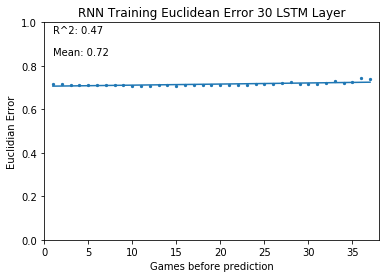

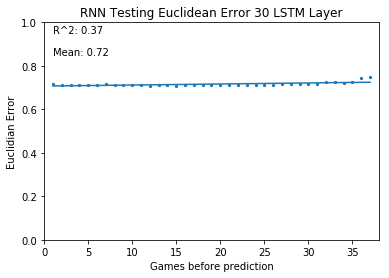

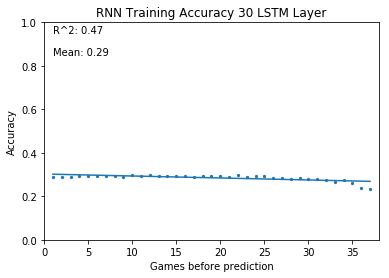

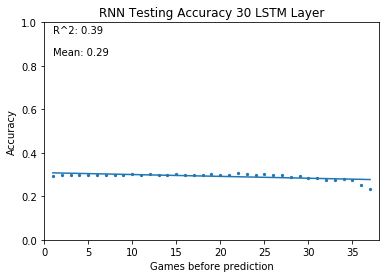

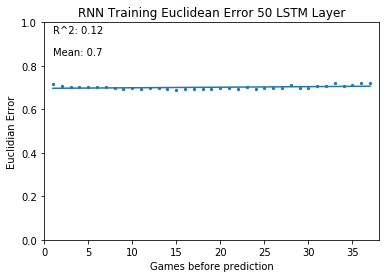

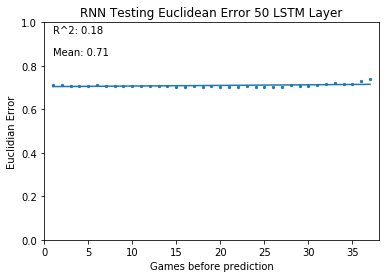

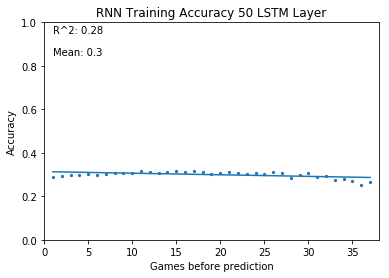

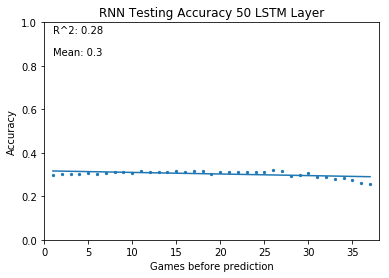

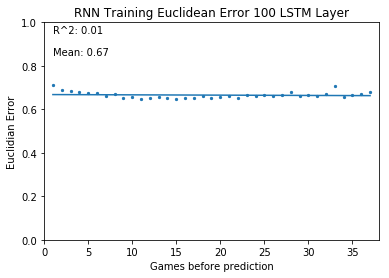

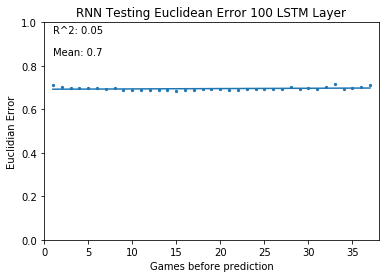

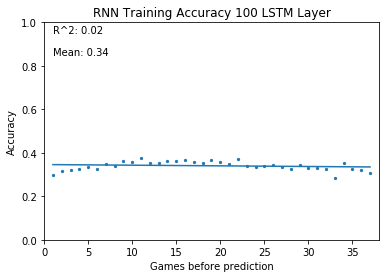

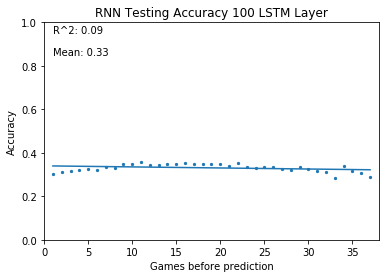

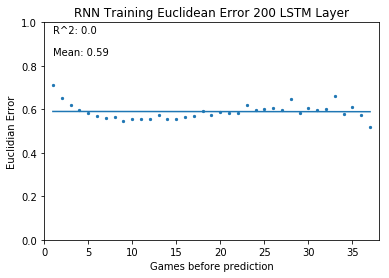

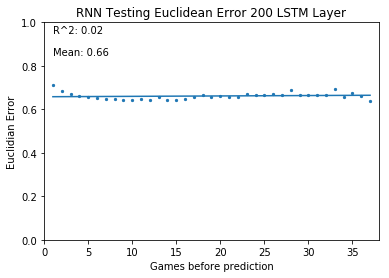

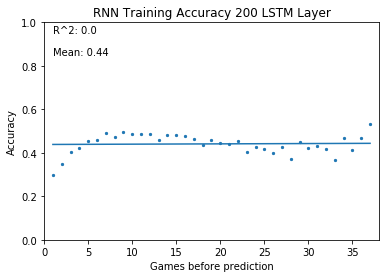

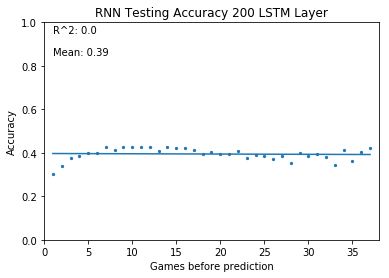

In [70]:
for size in layer_sizes:
    key = str(size)+'_neuron_layers'
    title = ' ' + str(size) + ' LSTM Layer'
    plot(training_errs_dict[key], 'Euclidian Error', 'RNN Training Euclidean Error' + title, 'rnn_training_error_plot_'+key)
    plot(testing_errs_dict[key], 'Euclidian Error', 'RNN Testing Euclidean Error' + title, 'rnn_testing_error_plot_'+key)
    plot(training_accs_dict[key], 'Accuracy', 'RNN Training Accuracy' + title, 'rnn_training_accuracy_plot_'+key)
    plot(testing_accs_dict[key], 'Accuracy', 'RNN Testing Accuracy' + title, 'rnn_testing_accuracy_plot_'+key)